# HW4 - SVM (with 변수 더미화)
4조(박예진, 임동욱, 조정윤, 홍정빈)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import math
import random

from sklearn.model_selection import train_test_split
from sklearn import metrics

from numba import jit

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
titanic_df = pd.read_csv("./train_titanic.csv")

In [3]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 1. 전처리

## 1-1. 범주형 처리하기

### 1-1-1. Name 전처리 & 피처 엔지니어링

In [5]:
# 이름 안에 있는 작위(?)들을 . 을 기준으로 정규식으로 추출한 후 Title 컬럼을 새로 만들어 거기에 담는다.
titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [6]:
titanic_df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Ms            1
Jonkheer      1
Sir           1
Mme           1
Lady          1
Don           1
Capt          1
Countess      1
Name: Title, dtype: int64

In [7]:
# 성별에 따른 작위의 수도 확인한다.
# -> 나중에 Mr, Miss, Mrs 중 무엇의 오타인지 확인하기 위함
name_sex = titanic_df
name_sex['Title'] = name_sex.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(name_sex['Title'], name_sex['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [8]:
# 거의 유니크한 작위들은 'Rare'로 통일하고
# Mlle, Ms, Mme는 오타인 것 같아 수정한다.
titanic_df['Title'] = titanic_df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')


In [9]:
# 만들어진 5개의 작위들에 번호를 부여한다.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)

In [10]:
# Name은 제거한다.
titanic_df = titanic_df.drop(['Name'], axis=1)

In [11]:
# 더미화
title_dum = pd.get_dummies(titanic_df['Title'], prefix='Title')
titanic_df = titanic_df.join(title_dum)

### 1-1-2. Sex 0과 1로 매핑

In [12]:
titanic_df.Sex = titanic_df.Sex.map({'male': 0, 'female': 1})

### 1-1-3. Embarked 0과 1로 매핑

In [13]:
# 더미화
emba_dum = pd.get_dummies(titanic_df['Embarked'], prefix='Embarked')

In [14]:
titanic_df = titanic_df.join(emba_dum)
titanic_df.drop(['Embarked'], axis=1, inplace=True)

### 1-1-4. Pclass 0과 1로 매핑

In [15]:
# 더미화
pclass_dum = pd.get_dummies(titanic_df['Pclass'], prefix='Pclass')

In [16]:
titanic_df = titanic_df.join(pclass_dum)

### 1-1-5. PassengerId, Ticket, Cabin 제거

In [17]:
titanic_df = titanic_df.drop(['PassengerId'], axis=1)
titanic_df = titanic_df.drop(['Ticket'], axis=1)
titanic_df = titanic_df.drop(['Cabin'], axis=1)

In [18]:
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Title_1,Title_2,Title_3,Title_4,Title_5,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,3,0,22.0,1,0,7.2500,1,1,0,0,0,0,0,0,1,0,0,1
1,1,1,1,38.0,1,0,71.2833,3,0,0,1,0,0,1,0,0,1,0,0
2,1,3,1,26.0,0,0,7.9250,2,0,1,0,0,0,0,0,1,0,0,1
3,1,1,1,35.0,1,0,53.1000,3,0,0,1,0,0,0,0,1,1,0,0
4,0,3,0,35.0,0,0,8.0500,1,1,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,5,0,0,0,0,1,0,0,1,0,1,0
887,1,1,1,19.0,0,0,30.0000,2,0,1,0,0,0,0,0,1,1,0,0
888,0,3,1,NaN,1,2,23.4500,2,0,1,0,0,0,0,0,1,0,0,1
889,1,1,0,26.0,0,0,30.0000,1,1,0,0,0,0,1,0,0,1,0,0


---

## 1-2. 연속형 처리하기

### 1-2-1. Age 전처리 & 피처 엔지니어링

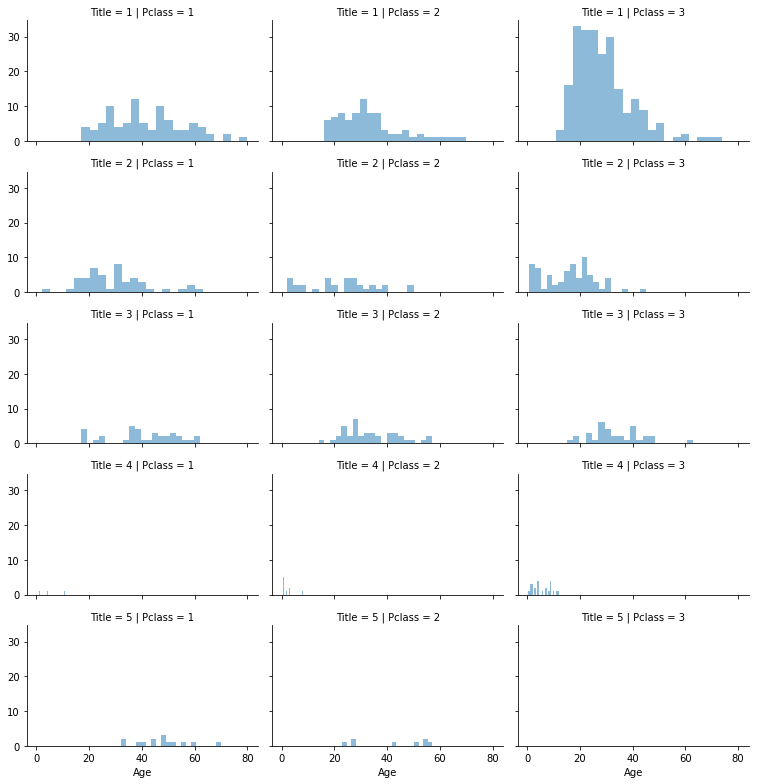

In [19]:
# Age의 null 값을 처리해야 한다.
# Pclass * Title과 Age 사이의 상관관계를 이용해 결측치를 채운다.

# 시각화
grid = sns.FacetGrid(titanic_df, row='Title', col='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [20]:
np.isnan(titanic_df.loc[888]['Age'])

True

In [21]:
titanic_df.loc[888]

Survived       0.00
Pclass         3.00
Sex            1.00
Age             NaN
SibSp          1.00
Parch          2.00
Fare          23.45
Title          2.00
Title_1        0.00
Title_2        1.00
Title_3        0.00
Title_4        0.00
Title_5        0.00
Embarked_C     0.00
Embarked_Q     0.00
Embarked_S     1.00
Pclass_1       0.00
Pclass_2       0.00
Pclass_3       1.00
Name: 888, dtype: float64

In [22]:
# 빈 age 리스트를 만들고 그 안에 Title과 Pclass에 따른 Age 값들 넣어주기.

age = [[[],[],[]], 
       [[],[],[]], 
       [[],[],[]], 
       [[],[],[]], 
       [[],[],[]]]

for i in range(0, len(titanic_df)):
    if np.isnan(titanic_df.loc[i]['Age']) == False :
        for t in range(1,6):
            for p in range(1,4):
                if (titanic_df.loc[i]['Title'] == t) & (titanic_df.loc[i]['Pclass'] == p):
                    age[t-1][p-1].append(titanic_df.loc[i]['Age'])


In [23]:
# 중앙값으로
age_median = [[[],[],[]], 
               [[],[],[]], 
               [[],[],[]], 
               [[],[],[]], 
               [[],[],[]]]

for i in range(0,5):
    for j in range(0,3):
        age_median[i][j].append(np.median(age[i][j]))

In [24]:
age_median

[[[40.0], [31.0], [26.0]],
 [[30.0], [24.0], [18.0]],
 [[40.0], [32.0], [31.0]],
 [[4.0], [1.0], [4.0]],
 [[48.5], [46.5], [nan]]]

In [25]:
# 평균값으로
age_mean = [[[],[],[]], 
           [[],[],[]], 
           [[],[],[]], 
           [[],[],[]], 
           [[],[],[]]]

for i in range(0,5):
    for j in range(0,3):
        age_mean[i][j].append(np.mean(age[i][j]))

In [26]:
age_mean

[[[41.58045977011494], [32.76829268292683], [28.724890829694324]],
 [[29.74468085106383], [22.560606060606062], [16.1231884057971]],
 [[40.4], [33.68292682926829], [33.515151515151516]],
 [[5.306666666666667], [2.2588888888888885], [5.350833333333334]],
 [[47.57142857142857], [42.0], [nan]]]

In [27]:
# age 리스트로 만든 평균값들을 원본 데이터의 결측값에 넣어주기.
# 데이터 수가 너무 적은 것은 중앙값보다는 평균값이 유리하다고 판단해서 전부 평균값으로 대체하기로 했다.
# (실제로 평균값을 넣었을 때 점수가 더 높다.)
for i in range(0, len(titanic_df)):
    if np.isnan(titanic_df.loc[i]['Age']) :
        for t in range(1,6):
            for p in range(1,4):
                if (titanic_df.loc[i]['Title'] == t) & (titanic_df.loc[i]['Pclass'] == p):
                    titanic_df.loc[i, 'Age'] = round(age_mean[t-1][p-1][0])  # 값을 넣을 때는 loc[i, 'Age'] 형태를 이용해야한다.



In [28]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Title       891 non-null    int64  
 8   Title_1     891 non-null    uint8  
 9   Title_2     891 non-null    uint8  
 10  Title_3     891 non-null    uint8  
 11  Title_4     891 non-null    uint8  
 12  Title_5     891 non-null    uint8  
 13  Embarked_C  891 non-null    uint8  
 14  Embarked_Q  891 non-null    uint8  
 15  Embarked_S  891 non-null    uint8  
 16  Pclass_1    891 non-null    uint8  
 17  Pclass_2    891 non-null    uint8  
 18  Pclass_3    891 non-null    uint8  
dtypes: float64(2), int64(6), uint

Text(0.5, 1.0, 'Age')

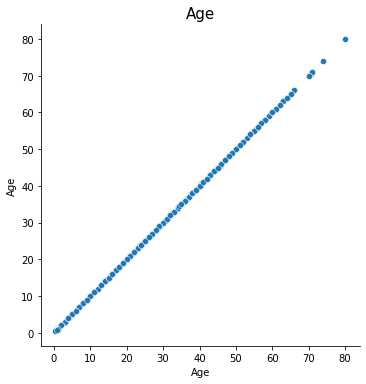

In [29]:
sns.relplot(x="Age", y="Age", data=titanic_df)
plt.title('Age', size=15)

Text(0.5, 1.0, 'Age')

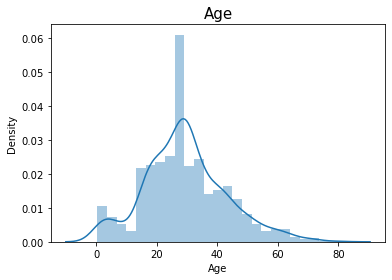

In [30]:
sns.distplot(titanic_df["Age"])
plt.title('Age', size=15)

In [31]:
titanic_df.loc[ titanic_df['Age'] < 20, 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] >= 20) & (titanic_df['Age'] < 30), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] >= 30) & (titanic_df['Age'] < 40), 'Age']   = 3
titanic_df.loc[(titanic_df['Age'] >= 40) & (titanic_df['Age'] < 50), 'Age']   = 4
titanic_df.loc[ titanic_df['Age'] >= 50, 'Age'] = 5
titanic_df['Age'] = titanic_df['Age'].astype(int)

titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Title_1,Title_2,Title_3,Title_4,Title_5,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,3,0,2,1,0,7.2500,1,1,0,0,0,0,0,0,1,0,0,1
1,1,1,1,3,1,0,71.2833,3,0,0,1,0,0,1,0,0,1,0,0
2,1,3,1,2,0,0,7.9250,2,0,1,0,0,0,0,0,1,0,0,1
3,1,1,1,3,1,0,53.1000,3,0,0,1,0,0,0,0,1,1,0,0
4,0,3,0,3,0,0,8.0500,1,1,0,0,0,0,0,0,1,0,0,1


In [32]:
age_dum = pd.get_dummies(titanic_df['Age'], prefix='Age')

In [33]:
titanic_df = titanic_df.join(age_dum)
titanic_df.drop(['Age'], axis=1, inplace=True)

### 1-2-2. Fare 전처리 & 피처 엔지니어링

In [34]:
# 이거 하니까 점수 더 낮아져서 일단 폐기

Text(0.5, 1.0, 'Fare')

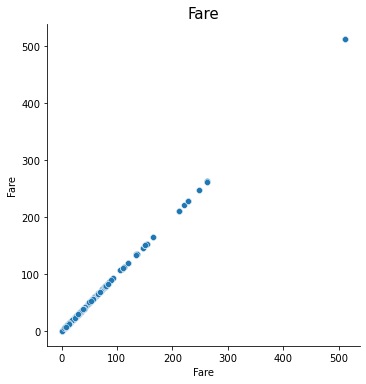

In [35]:
sns.relplot(x="Fare", y="Fare", data=titanic_df)
plt.title('Fare', size=15)

# 이상치를 확인할 수 있다.'''

Text(0.5, 1.0, 'Fare')

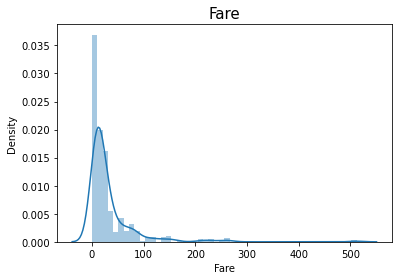

In [36]:
sns.distplot(titanic_df["Fare"])
plt.title('Fare', size=15)

In [37]:
#titanic_df['FareBand'] = pd.qcut(titanic_df['Fare'], 4)
#titanic_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

In [38]:
titanic_df.loc[ titanic_df['Fare'] <= 10, 'Fare'] = 0
titanic_df.loc[(titanic_df['Fare'] > 10) & (titanic_df['Fare'] <= 30), 'Fare'] = 1
titanic_df.loc[(titanic_df['Fare'] > 30) & (titanic_df['Fare'] <= 100), 'Fare']   = 2
titanic_df.loc[ titanic_df['Fare'] > 100, 'Fare'] = 3
titanic_df['Fare'] = titanic_df['Fare'].astype(int)

In [39]:
# 더미화
fare_dum = pd.get_dummies(titanic_df['Fare'], prefix='Fare')
titanic_df = titanic_df.join(fare_dum)

In [40]:
titanic_df.drop(['Fare'], axis=1, inplace=True)

### 1-2-3. SibSp & Parch 처리

In [41]:
# 두 컬럼을 합쳐 Family라는 새로운 컬럼 생성
titanic_df['Family'] = titanic_df['SibSp']+titanic_df['Parch']

Text(0.5, 1.0, 'Family')

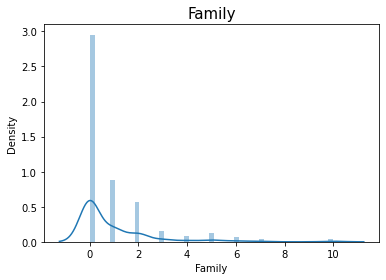

In [42]:
sns.distplot(titanic_df["Family"])
plt.title('Family', size=15)

In [43]:
# 혼자 탄 사람과 1명 이상의 가족과 함께 탄 사람으로 분리
titanic_df.loc[ titanic_df['Family'] == 0, 'Family'] = 0
titanic_df.loc[ titanic_df['Family'] >= 1, 'Family'] = 1

In [44]:
# 이제 안 쓰는 컬럼들은 제거
titanic_df.drop(['SibSp'], axis=1, inplace=True)
titanic_df.drop(['Parch'], axis=1, inplace=True)
titanic_df.drop(['Pclass'], axis=1, inplace=True)
titanic_df.drop(['Title'], axis=1, inplace=True)

In [45]:
# 모든 변수들을 0과 1로 더미화 완료
titanic_df.head(10)

,Survived,Sex,Title_1,Title_2,Title_3,Title_4,Title_5,Embarked_C,Embarked_Q,Embarked_S,...,Age_1,Age_2,Age_3,Age_4,Age_5,Fare_0,Fare_1,Fare_2,Fare_3,Family
0,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
1,1,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2,1,1,0,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
3,1,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,1
4,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
7,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1
8,1,1,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
9,1,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1


In [46]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    891 non-null    int64
 1   Sex         891 non-null    int64
 2   Title_1     891 non-null    uint8
 3   Title_2     891 non-null    uint8
 4   Title_3     891 non-null    uint8
 5   Title_4     891 non-null    uint8
 6   Title_5     891 non-null    uint8
 7   Embarked_C  891 non-null    uint8
 8   Embarked_Q  891 non-null    uint8
 9   Embarked_S  891 non-null    uint8
 10  Pclass_1    891 non-null    uint8
 11  Pclass_2    891 non-null    uint8
 12  Pclass_3    891 non-null    uint8
 13  Age_1       891 non-null    uint8
 14  Age_2       891 non-null    uint8
 15  Age_3       891 non-null    uint8
 16  Age_4       891 non-null    uint8
 17  Age_5       891 non-null    uint8
 18  Fare_0      891 non-null    uint8
 19  Fare_1      891 non-null    uint8
 20  Fare_2      891 non-null    uint

---
---

# 2. 모델링 - SVM

### Reference Link
- https://github.com/qandeelabbassi/python-svm-sgd/blob/master/svm.py
- https://github.com/adityajn105/SVM-From-Scratch/blob/master/Support%20Vector%20Machine%20From%20Scratch.ipynb
- https://github.com/adityajn105/SVM-From-Scratch/blob/master/Support%20Vector%20Machine%20From%20Scratch.ipynb
- https://jonchar.net/notebooks/SVM/
- https://nianlonggu.com/2019/07/04/tutorial-on-SVM/
- https://intrepidgeeks.com/tutorial/python-support-vector-machine-svm-source-code-smo-algorithm
- https://www.python-engineer.com/courses/mlfromscratch/07_svm/

In [68]:
class SVM:
    
    def __init__(self, C=1000, maxIterations=1000000):
        self.C = C                          # cost (pdf 19)
        self.maxIterations = maxIterations  # 최대 반복횟수
 
    # kernel 정의
    def kernel(vector1, vector2): # (pdf 14~16) 아래 커널 행렬을 만들 때 사용하기 위한 것
        if len(vector1) != len(vector2):
            print("kernel 함수에 입력된 두 벡터의 길이가 달라서 연산이 불가함")
            return 0
        count_zero = 0 # 두 벡터가 같은지 판별하려고 하는데 오류가 나와서, for문을 쓰기로 함
        vector_diff = np.array(vector1 - vector2)[0] # 둘이 같으면 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 나옴
        for i in range(len(vector_diff)):
            if vector_diff[i] == 0:
                count_zero += 1
        if count_zero == len(vector_diff):
            return 1
        else:
            return np.exp(-0.5 * ((vector1 - vector2) * (vector1 - vector2).T) / np.var(vector1 - vector2)) # sigma 반영 완료 함

    def kernel_matrix(matrix1, matrix2):  # 커널 행렬을 만들어서 while문의 연산에 사용
        n_matrix1 = matrix1.shape[0] #행렬의 shape 메소드는 (행, 열)의 튜플. 이 중 행 개수를 알고 싶으니 0번 인덱스 가지고 옴
        n_matrix2 = matrix2.shape[0]
        result = np.zeros([n_matrix1, n_matrix2]) # return 변수의 행렬 길이 선언
        for i in range(n_matrix1):
            for j in range(n_matrix2):
                if i == j:
                    result[i][j] = 1
                else: 
                    result[i][j] = SVM.kernel(matrix1[i], matrix2[j]) # i행 j열에 kernel 값 집어넣기
        return result

    @jit
    def smo_fit(self, X, Y):  # smo 함수로 바로 fit 한다.
        X = np.mat(X) # 데이터셋을 행렬의 형태로 X 변수에 저장하기
        Y = np.mat(Y).T
        y = []
        for i in range(len(Y)): # y값이 0과 1을 -1과 1로 바꿔줌
            if Y[i] == 0:
                y.append(-1)
            elif Y[i] == 1:
                y.append(1)
        r, c = np.shape(X)
        alpha = np.zeros((r,1))
        iter = 0
        b = 0 # b의 초기값 0
        b1 = 0
        b2 = 0

        kernel_mat = SVM.kernel_matrix(X, X) # kernel을 하나씩 계산하는 것보다 행렬로 선언해놓고, 불러오는 것이 더 빠를 것임 (동욱 생각) 

        while(iter < self.maxIterations):
            [i,j] = np.random.choice(r, 2, replace= False) # 두 개의 난수를 비복원추출로 뽑음. 0부터 len(Y)-1 까지의 수가 나옴, 함수 정의하면 속도 느려지는 듯
            eta = 2 * kernel_mat[i][j] - kernel_mat[i][i] - kernel_mat[j][j]
            if eta == 0:
                continue
            alpha_i_old = alpha[i].copy()
            alpha_j_old = alpha[j].copy()
            Ei = 0
            Ej = 0
            Ei = [alpha[k] * y[k] * kernel_mat[k,i] for k in range(r)]
            Ej = [alpha[k] * y[k] * kernel_mat[k,j] for k in range(r)]
            Ei = sum(Ei) + b - y[i]
            Ej = sum(Ej) + b - y[j]
            alpha[j] = alpha[j] - y[j] * (Ei- Ej) / eta

            if alpha[j] < 0.0001:
                alpha[j] = 0

            if y[i] != y[j]:  # 강의노트 25페이지
                Lower = max(0, - alpha_j_old - alpha_i_old)
                Upper = min(self.C, self.C - alpha_i_old + alpha_j_old)
            elif y[i] == y[j]:
                Lower = max(0, alpha_i_old + alpha_j_old - self.C)
                Upper = min(self.C, alpha_i_old + alpha_j_old)

            if alpha[j] >= Upper:
                alpha[j] = Upper
            elif alpha[j] < Lower:
                alpha[j] = Lower

            alpha[i] = alpha[i] + ( alpha_j_old - alpha[j] ) * y[i] * y[j]

            if alpha[i] < 0.0001:
                alpha[i] = 0

            if alpha[i] > 0 and alpha[i] < self.C:
                b1 = b - Ei + ( alpha_i_old - alpha[i] ) * y[i] * kernel_mat[i][i] + ( alpha_j_old - alpha[j] ) * y[j] * kernel_mat[j][i]
            elif alpha[j] > 0 and alpha[j] < self.C:
                b2 = b - Ej + ( alpha_i_old - alpha[i] ) * y[i] * kernel_mat[i][j] + ( alpha_j_old - alpha[j] ) * y[j] * kernel_mat[j][j]

            if 0 < alpha[i] and alpha[i] < self.C:
                b = b1
            elif 0 < alpha[j] and alpha[j] < self.C:
                b = b2
            else:
                b = (b1 + b2) / 2

            iter += 1

            # 시간 엄청 오래 걸려서 이걸로 잘 실행되고 있는지 확인하기
            if (iter % 10000) == 0: 
                print(int(iter/10000), '만 번까지 실행 완료', sep='')
                #print(f'{int(iter/10000)}만 번까지 실행완료. b값은 {b}') # 이렇게 하면 이상하게 오류가 생긴다;;

        return b, alpha
    
    
    def predict(x, y, a, b):
        X = np.mat(x)
        Y = np.mat(y).T
        y = []
        for i in range(len(Y)):
            if Y[i] == 0:
                y.append(-1)
            elif Y[i] == 1:
                y.append(1)
        def g(z):
            if (z < 0): return -1
            else: return 1
        pred_y = []
        for i in range(X.shape[0]):
            z = [a[k] * y[k] * kernel_mat[k,i] for k in range(X.shape[0])] # 이거는 z = w.T * x 까지만 하나하나씩 리스트로 계산한 것
            z = sum(z) + b # z = w.T * x * b
            pred_y.append(g(z))
        return np.array(pred_y)

In [69]:
X = titanic_df.drop(['Survived'], axis=1)
y = titanic_df.Survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2022)

In [70]:
svm_model = SVM(C=1000, maxIterations=1000000)
svm_model.smo_fit(X_train, y_train)  # 엄청 오래 걸린다.. 100만 번까지 반복해야하고, 1만 번 당 대략 1분 걸립니당ㅎㅎ
                                     # maxIteration 값을 낮추면 빨라질 수 있지만, 그만큼 정확도가 낮아질 수 있다.
# 너무 오래 걸리면 저 아래로 내려가서 코드 실행해주세요!!


1만 번까지 실행 완료


KeyboardInterrupt: 

In [ ]:
b = svm_model[0]
alpha = svm_model[1]
print(alpha)
print(b)

In [ ]:
pred_y = predict(x_train, y_train, alpha, b)
print(pred_y) # 예측 값 출력

In [ ]:
y_pred_svm = svm_model.predict(x_train, y_train, alpha, b)
print(y_pred_svm) 

## SVM 실행 속도가 너무 느린 관계로, 교수님께서 코드를 실행하는 데에 어려움이 있으실까봐
## 저희가 미리 모델 실행해서 얻은 y_pred 값을 따로 빼놨습니다.
(아래 코드들만 바로 실행하면 됩니다.)

In [71]:
y_pred_svm = [-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1
,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,1,1,1,-1,-1,-1,-1,-1,-1,-1
,-1,1,-1,1,1,-1,-1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,-1,1,-1,1,-1,-1
,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1
,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,1,1,-1,-1,1,1,-1,1,-1,-1,1
,-1,1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1
,-1,-1,-1,1,-1,1,1,1,-1,-1,-1,-1,1,1,1,1,-1,-1,1,-1,-1,1,-1,1
,-1,1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1
,1,1,1,-1,1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1
,-1,-1,-1,1,-1,-1,-1]

In [72]:
# -1을 0으로 변경
for i in range(len(y_pred_svm)):
    if y_pred_svm[i] == -1:
        y_pred_svm[i] = 0
print(y_pred_svm)

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [73]:
y_pred_svm= np.array(y_pred_svm)

In [74]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_svm))
print("Precision:", metrics.precision_score(y_test, y_pred_svm))
print("Recall:", metrics.recall_score(y_test, y_pred_svm))
print("F1_score:", metrics.f1_score(y_test, y_pred_svm))

Accuracy: 0.852017937219731
Precision: 0.8615384615384616
Recall: 0.7
F1_score: 0.7724137931034483
